In [81]:
import librosa
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener, fftconvolve
from scipy.linalg import toeplitz,  cho_factor, cho_solve
from sklearn.metrics import mean_squared_error
from IPython.display import Audio

import scipy.io.wavfile as wav


In [82]:
path = librosa.example("nutcracker")
Audio(path)

In [3]:
sample, sampling_rate = librosa.load(path)

start = 30
end = 36
sample = sample[int(sampling_rate * start):int(sampling_rate * end)]

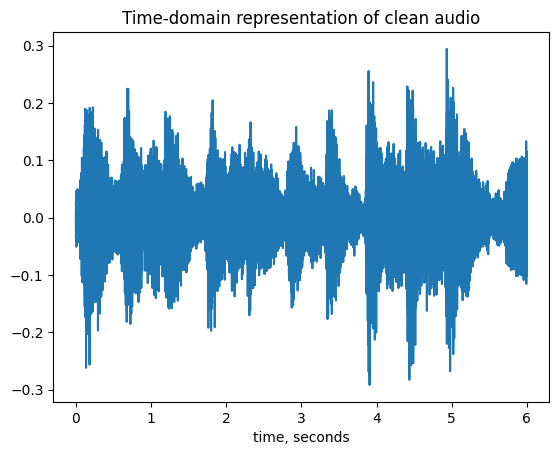

In [4]:
timer = np.array(range(sample.shape[0])) / sampling_rate
plt.plot(timer, sample)
plt.title('Time-domain representation of clean audio')
plt.xlabel('time, seconds')
plt.show()
Audio(sample, rate=sampling_rate)

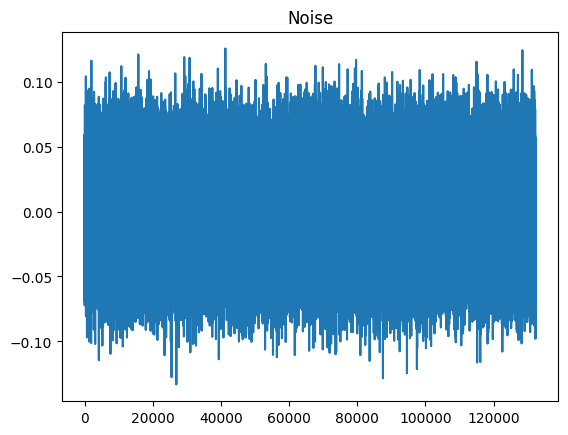

In [5]:
noise = np.random.normal(0, 0.03, sample.shape[0])

plt.plot(noise)
plt.title('Noise')
plt.show()

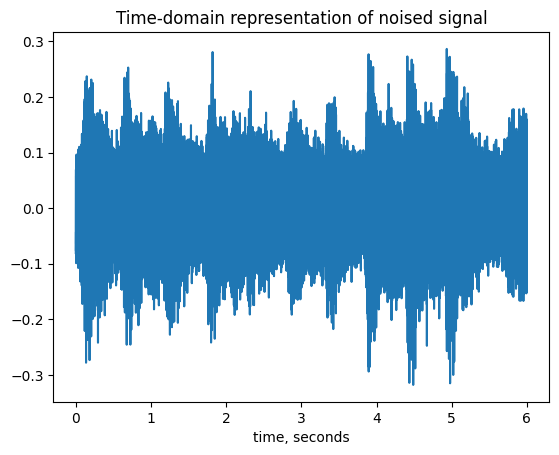

In [6]:
signal = sample + noise

plt.plot(timer, signal)
plt.title('Time-domain representation of noised signal')
plt.xlabel('time, seconds')
plt.show()

Audio(signal, rate=sampling_rate)

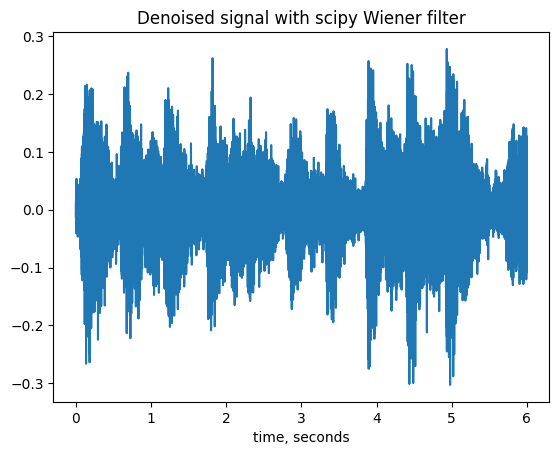

In [7]:
lib_wiener_filtered = wiener(signal, noise=np.var(noise), mysize=40)

plt.plot(timer, lib_wiener_filtered)
plt.title('Denoised signal with scipy Wiener filter')
plt.xlabel('time, seconds')
plt.show()

Audio(lib_wiener_filtered, rate=sampling_rate)

In [60]:
print(mean_squared_error(sample, lib_wiener_filtered))

0.00047730688531856774


In [61]:
def orthogonal_diag_inverse(matrix): #works much slower than inverse
    Q, D, Q_T = np.linalg.svd(matrix)
    D_inv = np.diag(D**-1)
    return Q@D_inv@Q_T

def cholesky(matrix, vec):
    c, low = cho_factor(matrix)
    return cho_solve((c, low), vec)
    


def optimal_filter(samples, noise):
    # start = time.time()
    correlation = fftconvolve(samples, samples[::-1])
    rxx = correlation[correlation.size//2:]
    autocorrelation_matrix = toeplitz(rxx, rxx)
    rvv = fftconvolve(noise, noise[::-1])
    rvv = rvv[rvv.size//2:]
    cross_correlation_estimate = rxx - rvv
    # end = time.time()
    # print(f"creating matrix and vectors: {end-start}")
    # start = time.time()
    # handmade, faster at small matrices
    # filter = orthogonal_diag_inverse(autocorrelation_matrix)@cross_correlation_estimate 

    #cholesky experiments
    filter = cholesky(autocorrelation_matrix, cross_correlation_estimate)
    
    # built-in, faster at big matrices
    # filter = np.linalg.inv(autocorrelation_matrix)@cross_correlation_estimate
    # end = time.time()
    # print(f"solving matrix: {end-start}")
    return filter


def wiener_filter(last_samples, noise_sample):
    filter = optimal_filter(last_samples, noise_sample)
    return filter.T@last_samples



In [74]:
windowsize = 80
filtered_us = np.zeros(signal.size)
for i in range(1, signal.size):
    print(i)
    filtered_us[i] = wiener_filter(signal[max(0, i-windowsize):i],
                                    noise[max(0, i-windowsize):i])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


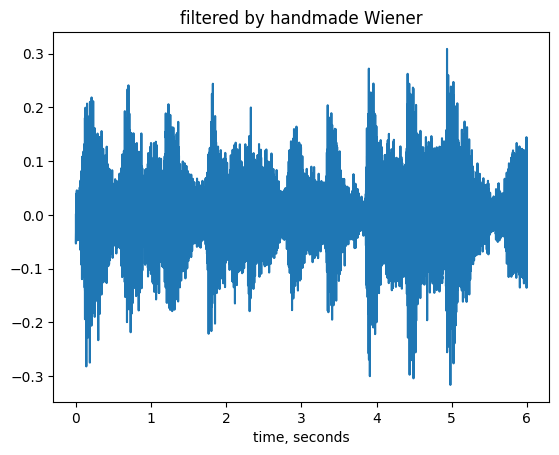

In [75]:

plt.plot(timer, filtered_us)
plt.title("filtered by handmade Wiener")
plt.xlabel("time, seconds")
plt.show()
Audio(filtered_us, rate=sampling_rate)


In [76]:
print(mean_squared_error(sample, filtered_us))

0.0050630108705286715


In [45]:
def LMS_iterative(last_samples, noise_sample):
    speech_estimate = np.var(last_samples) + np.var(noise_sample)
    weights = np.zeros(last_samples.size)
    correlation = fftconvolve(last_samples, last_samples[::-1])
    rxx = correlation[correlation.size//2:]
    autocorrelation_matrix = toeplitz(rxx, rxx)
    rvv = fftconvolve(noise_sample, noise_sample[::-1])
    rvv = rvv[rvv.size//2:]
    cross_correlation_estimate = rxx - rvv
    vals =np.linalg.eigvalsh(autocorrelation_matrix)
    mu = 2/(np.amin(vals) + np.amax(vals))
    sample_est= last_samples[-1] - noise_sample[-1]
    error = sample_est -  weights.T@last_samples
    mse =  speech_estimate - (2*cross_correlation_estimate + weights@autocorrelation_matrix)@weights
    prev_mse = mse
    it = 0
    max_it = 10
    while mse<=prev_mse and it < max_it:
        prev_mse = mse
        it+=1
        error = sample_est - weights.T@last_samples
        weights = weights + (2*mu*error)*last_samples
        mse = speech_estimate - (2*(cross_correlation_estimate) + weights@autocorrelation_matrix)@weights
    return weights.T@last_samples

In [50]:
windowsize = 60
filtered_lms = np.zeros(signal.size)
for i in range(windowsize, signal.size):
    print(i)
    filtered_lms[i] = LMS_iterative(signal[max(0, i-windowsize):i],
                                    noise[max(0, i-windowsize):i])

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319


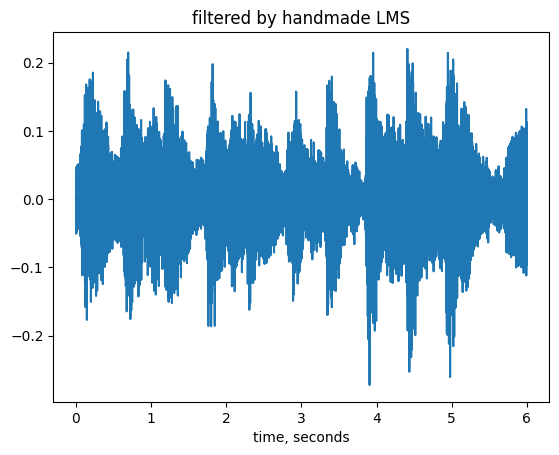

In [59]:
plt.plot(timer, filtered_lms)
plt.title("filtered by handmade LMS")
plt.xlabel("time, seconds")
plt.show()
Audio(filtered_lms, rate=sampling_rate)


In [58]:
print(mean_squared_error(sample, filtered_lms))

0.0004908070314040993


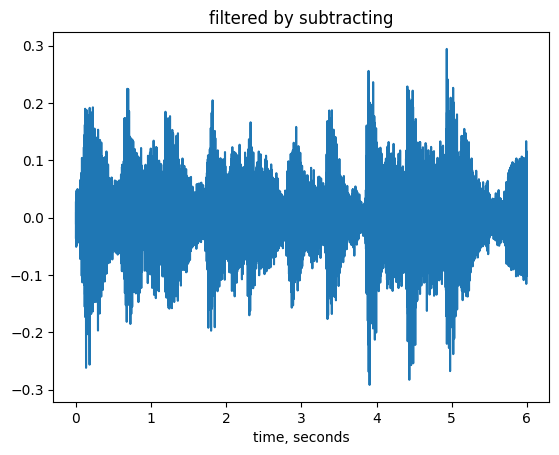

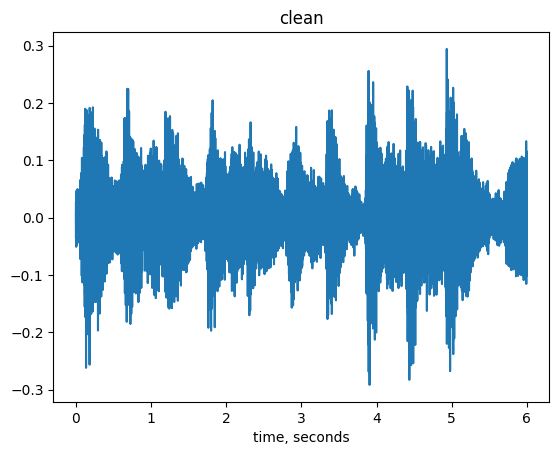

In [55]:
plt.plot(timer, signal-noise)
plt.title("filtered by subtracting")
plt.xlabel("time, seconds")
plt.show()
plt.plot(timer, sample)
plt.title("clean")
plt.xlabel("time, seconds")
plt.show()
Audio(signal-noise, rate=sampling_rate)



In [56]:
Audio(sample, rate=sampling_rate)

<h1>TEST WITH THE OUR SAMPLE</h1>

In [86]:
data_t = wav.read("recorded1.wav")
sound_t = np.array(data_t[1], dtype=np.float32)
sample_t, sampling_rate_t = librosa.load(sound_t)
Audio(sample_t)

TypeError: Invalid file: array([-2013., -2048., -2088., ..., -5098., -5056., -4909.], dtype=float32)